# Sembradora 3000

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import random
import numpy as np
from collections import namedtuple, deque
from queue import PriorityQueue
from itertools import count
import math

# Visualization
import imageio
import imageio.v2 as imageio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

# Guardar
import pickle

# Sistema
import os

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Grid

In [2]:
"""
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

def is_connected(grid, free_positions):
    """Check if all free cells are connected using BFS."""
    n = grid.shape[0]
    visited = set()
    queue = deque([free_positions.pop()])
    visited.add(queue[0])

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    connected_count = 1
    free_count = len(free_positions)

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if (0 <= new_x < n and 0 <= new_y < n and 
                (new_x, new_y) in free_positions and (new_x, new_y) not in visited):
                queue.append((new_x, new_y))
                visited.add((new_x, new_y))
                connected_count += 1
                
    return connected_count == free_count

def generate_grid(model, n, obstacles_count):
    """Generate a grid with obstacles, ensuring free cells are connected."""
    while True:
        grid = ap.Grid(model, (n, n), track_empty=True)
        grid.add_field("occupied", 0)

        obstacle_positions = set()
        while len(obstacle_positions) < obstacles_count:
            pos = (random.randint(0, n-1), random.randint(0, n-1))
            if pos not in obstacle_positions and pos not in model.p.seedsPositions:
                obstacle_positions.add(pos)

        for pos in obstacle_positions:
            grid["occupied"][pos] = 1

        free_positions = {(x, y) for x in range(n) for y in range(n) if grid["occupied"][x, y] == 0}
        
        if is_connected(grid, free_positions):
            break

    for pos in obstacle_positions:
        grid["occupied"][pos] = 1
        model.np_grid[pos] = 3

    agentlist = ap.AgentList(model, len(obstacle_positions), agent_type=2)
    grid.add_agents(agentlist, obstacle_positions)
    
    model.grid = grid
    
    return obstacle_positions

## Agente

In [3]:
class CollectingTractor(ap.Agent):
    def setup(self):
        """Initialize agent parameters."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset agent attributes."""
        if not self.initialized:
            self._initialize_agent()
        else:
            self._restore_agent()

    def _initialize_agent(self):
        """Initialize the agent's initial state."""
        self.collected = 0
        self.targetIndex = 1
        self.destroyed = False
        self.condition = True
        self.seeds = 0
        self.type = 1
        self.pos = (0, 0)

        # Initialize Q-learning parameters
        self.q_table = np.zeros((self.p.grid_size, self.p.grid_size, 6))
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.990

        self.initialized = True  # Mark as initialized

    def _restore_agent(self):
        """Restore the agent's state to its initial conditions."""
        self.collected = 0
        self.targetIndex = 1
        self.destroyed = False
        self.condition = True
        self.seeds = 0

        # Restore Q-learning parameters to initial state
        self.epsilon = 1.0

    def move(self, dx=0, dy=0):
        """Move the tractor by (dx, dy)."""
        x, y = self.pos
        new_pos = (x + dx, y + dy)

        if 0 <= new_pos[0] < self.p.grid_size and 0 <= new_pos[1] < self.p.grid_size:
            self.model.grid.move_to(self, new_pos)
            self.pos = new_pos
            return new_pos, True
        return self.pos, False

    def move_up(self):
        return self.move(dy=1)

    def move_down(self):
        return self.move(dy=-1)

    def move_left(self):
        return self.move(dx=-1)

    def move_right(self):
        return self.move(dx=1)

    def drop(self):
        """Drop seeds at the current target position."""
        if self.seeds > 0 and self.pos == self.targets[self.targetIndex]:
            self.targetIndex += 1
            self.seeds -= 1
            self.destroyed = self.targetIndex >= len(self.targets)
            return self.pos, True
        return self.pos, False

    def collect(self):
        """Collect seeds if available at the current position."""
        if self.model.np_grid[self.pos] == 4:
            self.seeds = self.capacity
            return self.pos, 1 if self.seeds == 0 else 2
        return self.pos, 3

    def get_reward(self, action, agents, accionado):
        """Calculate the reward based on the action and outcome."""
        reward = -1  # Base penalty for movement
        
        # Calculate the distance to the current target
        target_pos = self.targets[self.targetIndex]
        distance_to_target = np.linalg.norm(np.array(self.pos) - np.array(target_pos))
        
        # Reduce penalty based on proximity to the target
        proximity_bonus = max(0, (self.p.grid_size - distance_to_target) / self.p.grid_size)
        
        if action in [0, 1, 2, 3]:  # Movement actions
            reward += -2 if not accionado else 0
        elif action == 4:  # Drop seeds
            reward = 100 if accionado else -15
        elif action == 5:  # Collect seeds
            reward = {1: 50, 2: -2, 3: -5}[accionado]
        
        # Add the proximity bonus to reward
        reward += proximity_bonus
        
        # Penalty for collision with other agents
        if any(agent != self and agent.pos == self.pos for agent in agents):
            reward -= 5

        # Penalty for collision with obstacles
        if self.model.np_grid[self.pos] == 2:
            reward -= 7

        return reward


    def q_learning_update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning algorithm."""
        x, y = state
        next_x, next_y = next_state
        current_q = self.q_table[x, y, action]
        max_next_q = np.max(self.q_table[next_x, next_y])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[x, y, action] = new_q

    def acciones(self, action):
        """Map action to the corresponding method."""
        action_map = {
            0: self.move_up,
            1: self.move_down,
            2: self.move_left,
            3: self.move_right,
            4: self.drop,
            5: self.collect
        }
        return action_map[action]()

    def step(self, agents):
        """Execute a step in the agent's behavior."""
        if self.destroyed:
            return

        state = self.pos
        x, y = state
        
        # Action selection using epsilon-greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice([0, 1, 2, 3, 4, 5])
        else:
            action = np.argmax(self.q_table[x, y])
        
        # Decay epsilon to reduce exploration over time
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Execute the action and update Q-table
        next_state, accionado = self.acciones(action)
        reward = self.get_reward(action, agents, accionado)
        self.q_learning_update(state, action, reward, next_state)

## Ambiente

In [4]:
class TractorModel(ap.Model):
    def setup(self):
        """Initialize the environment and generate coordinates."""
        self.initialized = False
        self.reset()

    def reset(self):
        """Reset or initialize the model state."""
        if not self.initialized:
            self._initialize_environment()
        else:
            self._restore_environment()

        self.steps = 0  # Reset the step counter

    def _initialize_environment(self):
        """Initialize the environment, agents, and their targets."""
        self.Collected = 0
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))

        # Generate and store obstacle positions
        occupied_positions = generate_grid(self, self.p.grid_size, self.p.obstacles_count)
        self.obstacle_positions = np.copy(self.grid["occupied"])

        # Create agents and assign initial properties
        self.agents = ap.AgentList(self, self.p.number_of_tractors, CollectingTractor)
        self._initialize_agents(occupied_positions)

        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])
        
        # Add targets to the grid
        for tractor in self.agents:
            for target in tractor.targets:
                self.np_grid[target] = 3
        self.initialized = True  # Mark as initialized

    def _restore_environment(self):
        """Restore the environment to its initial state."""
        self.Collected = 0
        self.steps = 0
        self.max_steps = self.p.max_steps
        self.grid["occupied"] = np.copy(self.obstacle_positions)
        self.np_grid = np.zeros((self.p.grid_size, self.p.grid_size))
        
        # Restore obstacles
        for pos in self.obstacle_positions:
            self.np_grid[pos] = 2

        # Restore targets and positions
        for tractor, targets in zip(self.agents, self.targets_by_tractor):
            tractor.reset()  # Reset each agent
            tractor.targets = targets
            for target in targets:
                self.np_grid[target] = 3
            tractor.pos = targets[0]
            self.np_grid[tractor.pos] = 1
            
            
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.targetIndex = 1
        self.agents.destroyed = False
        self.grid.add_agents(self.agents, [tractor.pos for tractor in self.agents])

    def _initialize_agents(self, occupied_positions):
        """Initialize agents with positions and targets."""
        self.agents.capacity = self.p.capacity
        self.agents.seeds = self.p.starting_seeds
        self.agents.targetIndex = 1
        self.agents.destroyed = False

        self.coordsUsed = set(occupied_positions)
        self.targets_by_tractor = []

        for tractor in self.agents:
            targets = self._generate_targets_for_tractor()
            self.targets_by_tractor.append(targets)
            tractor.targets = targets
            tractor.pos = targets[0]
            self.np_grid[tractor.pos] = 1

        # Store a map of target positions
        self.target_positions = {pos for targets in self.targets_by_tractor for pos in targets}

    def _generate_targets_for_tractor(self):
        """Generate target positions for a tractor."""
        targets = []
        for _ in range(self.p.number_of_targets + 1):
            pos = self._get_free_position()
            targets.append(pos)
            self.coordsUsed.add(pos)
        return targets

    def _get_free_position(self):
        """Get a free position on the grid."""
        while True:
            x, y = random.randint(0, self.p.grid_size - 1), random.randint(0, self.p.grid_size - 1)
            if self.grid["occupied"][(x, y)] == 0 and (x, y) not in self.coordsUsed:
                return (x, y)

    def step(self):
        """Execute a step in the simulation."""
        for seed in self.p.seedsPositions:
            self.np_grid[seed] = 4

        self.steps += 1
        self.agents.step(self.agents)

        if self.steps >= self.max_steps:
            for tractor in self.agents:
                tractor.destroyed = True

    def end(self):
        """Report the total number of targets at the end of the simulation."""
        self.report('Total targets', self.p.number_of_targets * self.p.number_of_tractors)


## Animation

In [5]:
"""
0 is empty
1 is tractor
2 is obstacle
3 is target
4 is seeds
"""

# Load images
tractor_img = mpimg.imread('tractor.png')
obstacle_img = mpimg.imread('obstacle.png')
target_img = mpimg.imread('target.png')
seeds_img = mpimg.imread('seeds.png')

def save_frame(model, filename):
    fig, ax = plt.subplots()
    # Clear the axis to avoid over-plotting
    ax.clear()

    # Plot the grid using images
    for (x, y), value in np.ndenumerate(model.np_grid):
        if value == 1:  # Tractor
            ax.imshow(tractor_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 2:  # Obstacle
            ax.imshow(obstacle_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 3:  # Target
            ax.imshow(target_img, extent=[y, y+1, x, x+1], aspect='auto')
        elif value == 4:  # Seeds
            ax.imshow(seeds_img, extent=[y, y+1, x, x+1], aspect='auto')

    # Add text for each tractor displaying the number of seeds it has
    for agent in model.agents:
        if agent.destroyed:
            continue
        ax.text(agent.pos[1] + 0.5, agent.pos[0] + 0.5, str(agent.seeds),
                color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Fix axis limits based on the grid dimensions
    ax.set_xlim([0, model.np_grid.shape[1]])
    ax.set_ylim([0, model.np_grid.shape[0]])

    # Set aspect ratio to 'equal' to prevent image stretching
    ax.set_aspect('equal')

    # Set the title for the plot
    ax.set_title(f"Tractor model \n Time-step: {model.steps}, Collected: {model.Collected}")

    # Save the frame
    plt.savefig(filename)
    plt.close()

def create_gif(filenames, gif_filename):
    with imageio.get_writer(gif_filename, mode='I', duration=0.1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
def delete_temp_frames(prefix):
    for filename in os.listdir():
        if prefix in filename:
            os.remove(filename)

## Parameters

In [6]:


tractorParameters = {
    'grid_size': 10,
    'obstacles_count': 10,
    'number_of_tractors': 2,
    'number_of_targets': 20,
    'max_steps': 100,
    'seedsPositions': [(0, 0)],
    'capacity': 2,
    'starting_seeds': 2,
}

## Machine Learning

In [7]:
# Aprendizaje:
num_episodes = 3
rewards_per_episode = []
epsilon_values = []

model = TractorModel(tractorParameters)
model.setup()

for episode in range(num_episodes):
    model.reset()
    total_reward = 0

    # Primer episodio: sin exploración 
    if episode == 0:  
        # Store frames for the final episode
        filenames = []
        while model.steps < model.max_steps:
            filename = f'frame_{model.steps}.png'
            save_frame(model, filename)
            filenames.append(filename)
            model.step()  # Ejecutar un paso en el modelo
            total_reward += sum([tractor.get_reward(0, model.agents, False) for tractor in model.agents])

            # Verificar si todos los tractores están destruidos y romper el loop
            if all([tractor.destroyed for tractor in model.agents]):
                break

        # Create the GIF from saved frames
        create_gif(filenames, '1rstSimulacionTractores.gif')

        # Delete temporary frame files
        delete_temp_frames('frame')
        
    # Último episodio: 
    if episode == num_episodes - 1:  
        for tractor in model.agents:
            tractor.epsilon = 0.0
        
        # Store frames for the final episode
        filenames = []
        while model.steps < model.max_steps:
            filename = f'frame_{model.steps}.png'
            save_frame(model, filename)
            filenames.append(filename)
            model.step()  # Ejecutar un paso en el modelo
            total_reward += sum([tractor.get_reward(0, model.agents, False) for tractor in model.agents])

            # Verificar si todos los tractores están destruidos y romper el loop
            if all([tractor.destroyed for tractor in model.agents]):
                break

        # Create the GIF from saved frames
        create_gif(filenames, 'lastSimulacionTractores.gif')

        # Delete temporary frame files
        delete_temp_frames('frame')

    # Loop para los pasos dentro del episodio
    while model.steps < model.max_steps:
        model.step()  # Ejecutar un paso en el modelo
        total_reward += sum([tractor.get_reward(0, model.agents, False) for tractor in model.agents])

        # Verificar si todos los tractores están destruidos y romper el loop
        if all([tractor.destroyed for tractor in model.agents]):
            break

    rewards_per_episode.append(total_reward)
    epsilon_values.append(model.agents[0].epsilon)

    # Monitorear el progreso cada 100 episodios
    if episode % 10 == 0:
        print(f'Episodio {episode + 1}/{num_episodes}, Recompensa total: {total_reward:.2f}, Epsilon: {model.agents[0].epsilon:.2f}')

Episodio 1/3, Recompensa total: -955.70, Epsilon: 0.37


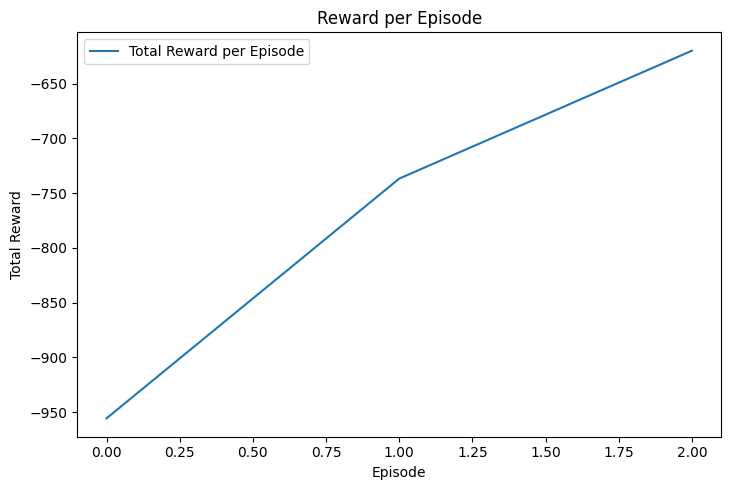

In [8]:
# Guardar la Q-table al final del entrenamiento
q_table = model.agents[0].q_table  # Asumiendo que todos los agentes comparten la misma Q-table
with open('q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

# Graficar el rendimiento
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend()

plt.tight_layout()
plt.show()

Final execution

In [9]:
'''
# Asignar la Q-table cargada a los agentes
model = TractorModel(tractorParameters)
model.setup()

for agent in model.agents:
    agent.q_table = q_table  # Asignar la Q-table cargada a cada agente

# Ahora puedes continuar entrenando o simular el comportamiento
model.reset()  # Resetear el ambiente si es necesario
model.step()  # Ejecutar pasos del modelo utilizando la Q-table cargada
'''


'\n# Asignar la Q-table cargada a los agentes\nmodel = TractorModel(tractorParameters)\nmodel.setup()\n\nfor agent in model.agents:\n    agent.q_table = q_table  # Asignar la Q-table cargada a cada agente\n\n# Ahora puedes continuar entrenando o simular el comportamiento\nmodel.reset()  # Resetear el ambiente si es necesario\nmodel.step()  # Ejecutar pasos del modelo utilizando la Q-table cargada\n'